# Import 

In [26]:
import os
import json
from pathlib import Path
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import torchvision.models as models
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
import cv2
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster, linkage
from collections import defaultdict
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import pandas as pd

from skimage.feature import graycomatrix, graycoprops


# Indexing artist folders with metadata

Parses folder names to extract artist info and builds a JSON index of all `.jpg` paintings, including image size and artist metadata.


In [25]:
def parse_folder_name(folder_name):
    """
    Parses a painter folder name to extract artist information.
    
    Args:
        folder_name (str): Folder name in format "CODE - NAME_BIRTHYEAR"
    
    Returns:
        dict: Dictionary containing artist code, full name and birth year
              Returns None if parsing fails
    """
    try:
        code, remainder = folder_name.split(" - ")
        name, birth_year = remainder.rsplit("_", 1)
        return {
            "artist_code": code.strip(),
            "full_name": name.strip(),
            "birth_year": int(birth_year)
        }
    except Exception as e:
        print(f"Error parsing folder: {folder_name} — {e}")
        return None

def create_index(base_dir="../bd-peintres-v6", index_file="index.json"):
    """
    Creates an index of all paintings with metadata including image dimensions.
    
    Args:
        base_dir (str): Path to directory containing artist folders
        index_file (str): Path to save the JSON index file
    
    Returns:
        dict: The created index dictionary with added image dimensions
    """
    base_path = Path(base_dir)
    index = {}

    for painter_folder in base_path.iterdir():
        if painter_folder.is_dir():
            meta = parse_folder_name(painter_folder.name)
            if not meta:
                continue
                
            images = list(painter_folder.glob("*.jpg"))
            for img_path in images:
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        
                    index[str(img_path)] = {
                        "artist_code": meta["artist_code"],
                        "full_name": meta["full_name"],
                        "birth_year": meta["birth_year"],
                        "width": width,
                        "height": height
                    }
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    continue

    with open(index_file, "w", encoding="utf-8") as f:
        json.dump(index, f, indent=2)

    return index

# Custom PyTorch Dataset for Paintings

Loads paintings with artist metadata and returns image tensors with numerical artist labels for training.


In [24]:
class PaintingDataset(Dataset):
    """PyTorch dataset for loading paintings with artist metadata.
    
    Args:
        image_paths (list): List of paths to painting images
        full_index (dict): Dictionary containing metadata for all paintings
        transform (callable, optional): Optional transform to be applied to images
    """
    
    def __init__(self, image_paths, full_index, transform=None):
        self.image_paths = image_paths
        self.index = full_index
        self.transform = transform
        
        # Create mapping from artist codes to numerical labels
        self.artist_codes = sorted(list({self.index[p]["artist_code"] for p in self.image_paths}))
        self.label_map = {code: idx for idx, code in enumerate(self.artist_codes)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """Loads and returns a single painting with its label.
        
        Args:
            idx (int): Index of the painting to load
            
        Returns:
            tuple: (image_tensor, label) where label is the artist's numerical ID
        """
        path = self.image_paths[idx]
        
        # Load image
        img = Image.open(path).convert("RGB")
        
        # Apply transforms if specified
        if self.transform:
            img = self.transform(img)
        
        # Convert to tensor if not already transformed
        if isinstance(img, Image.Image):
            img = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0
        
        # Get artist label
        label = self.label_map[self.index[path]["artist_code"]]
        
        return img, label

    @property
    def num_classes(self):
        """Returns the number of unique artists in the dataset."""
        return len(self.artist_codes)

# Image transform & index loader

Defines an image preprocessing pipeline for model input and loads (or creates) the painting metadata index.


In [22]:
def create_image_transform(target_size=(224, 224)):
    """
    Creates a transformation pipeline to prepare images for the model.
    
    Args:
        target_size (tuple): Desired output size (height, width)
        
    Returns:
        callable: Function that takes PIL Image and returns normalized tensor
    """
    def transform(img):
        # Resize image
        img = img.resize(target_size)
        # Convert to numpy array
        img_array = np.array(img)
        # Convert to tensor and normalize [0,255] -> [0,1]
        img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).float() / 255.0
        return img_tensor
    
    return transform

def load_or_create_index(index_path="index.json"):
    """
    Loads existing index or creates new one if not found.
    
    Args:
        index_path (str): Path to index JSON file
        
    Returns:
        dict: The loaded or created index
    """
    try:
        with open(index_path, "r") as f:
            index = json.load(f)
        print("Loaded existing index file.")
    except FileNotFoundError:
        print("Index not found. Creating new index...")
        index = create_index()
    return index

In [23]:
index = load_or_create_index()

Loaded existing index file.


# Display a painting with metadata

Shows a painting from the index along with artist info, dimensions, and filename. Supports random or specific selection.


In [6]:
def plot_painting(index, idx=None):
    """
    Displays a painting image with its metadata from the index.
    
    Args:
        index (dict): The index dictionary containing paths and metadata
        idx (int/str, optional): Either an integer index or direct image path. 
                               If None, displays random painting.
    
    Displays:
        - The painting image
        - Filename as title
        - Artist information
    """
    # Handle different input types
    if isinstance(idx, str):  # Direct path provided
        path = idx
    elif isinstance(idx, int):  # Numerical index provided
        path = list(index.keys())[idx]
    else:  # Random selection if no index specified
        keys_list = list(index.keys())
        random_idx = np.random.randint(0, len(keys_list))
        path = keys_list[random_idx]
        print(f"Randomly selected index: {random_idx}")
        
    
    # Load and convert image
    img = Image.open(path).convert("RGB")
    
    # Get metadata
    metadata = index[path]
    
    info_text = (f"Artist: {metadata['full_name']}\n"
                 f"Code: {metadata['artist_code']}\n"
                 f"Birth Year: {metadata['birth_year']}\n"
                 f"Dimensions: {metadata['width']}x{metadata['height']}")
    print(info_text)
    # Create figure
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    
    # Add title with filename
    plt.title(f"Painting: {Path(path).name}", pad=20)
    plt.show()

Randomly selected index: 6123
Artist: nicolas-poussin
Code: poussin
Birth Year: 1594
Dimensions: 1800x1267


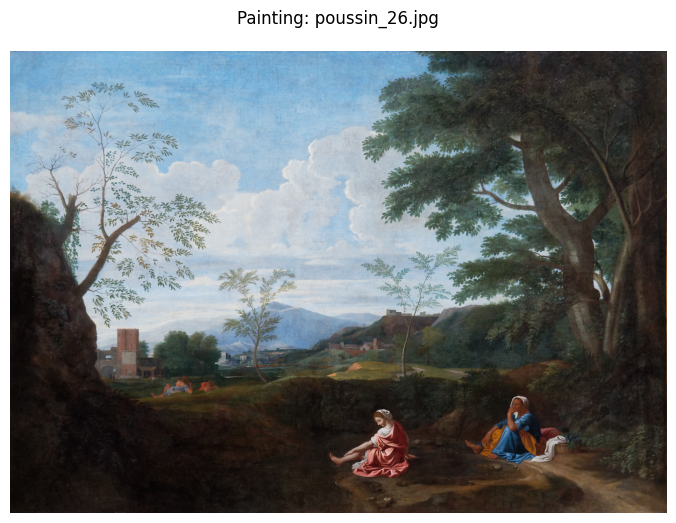

In [7]:
plot_painting(index) # random if no index provided

# Formation of Perfect Rectangular Clusters
This section of the code transforms each group of similar patches into a perfect rectangular or square shape, ideal for use with deep learning models.

- Each rectangle has dimensions proportional to the patch size (typically 224×224), ensuring compatibility with standard CNN input formats.

- The algorithm computes the bounding rectangle of each cluster based on patch positions.

- It then fills the entire rectangle, by:

    - Including only the patches that are sufficiently similar to the core cluster (based on color histogram similarity).

    - Ignoring patches that are too dissimilar.

- The result is a set of clean, perfect rectangular regions — even if that means adding or skipping patches — ready for training or inference.

- Overlapping between clusters is allowed, and the full image is preserved.

In [8]:
def get__patches(index, idx=None, patch_size=224, show=False):
    def mirror_pad_single_side(img, original_width, original_height):
        img_np = np.array(img)

        if original_height > original_width:
            pad = original_height - original_width
            mirror = img_np[:, -1*pad:][:, ::-1]
            img_np = np.concatenate([img_np, mirror], axis=1)  # pad to the right
        elif original_width > original_height:
            pad = original_width - original_height
            mirror = img_np[-1*pad:, :][::-1, :]
            img_np = np.concatenate([img_np, mirror], axis=0)  # pad to the bottom

        return Image.fromarray(img_np)

    # --- Step 1: get image path ---
    if isinstance(idx, str):
        path = idx
    elif isinstance(idx, int):
        path = list(index.keys())[idx]
    else:
        keys_list = list(index.keys())
        random_idx = np.random.randint(0, len(keys_list))
        path = keys_list[random_idx]
        print(f"Randomly selected index: {random_idx}")

    # --- Step 2: load image and get dimensions ---
    img = Image.open(path).convert("RGB")
    w, h = img.size
    img = mirror_pad_single_side(img, w, h)

    # --- Step 3: crop to multiple of patch size ---
    side = img.size[0]  # image is square now
    crop_size = side - (side % patch_size)
    img = img.crop((0, 0, crop_size, crop_size))
    img_np = np.array(img)

    # --- Step 4: extract all patches ---
    patches_list = []
    positions = []
    variances = []
    
    for y in range(0, crop_size, patch_size):
        for x in range(0, crop_size, patch_size):
            patch = img_np[y:y+patch_size, x:x+patch_size]
            patch_var = np.var(patch) if len(patch.shape) == 2 else np.var(patch, axis=(0,1)).mean()
            
            patches_list.append(patch)
            positions.append((x, y))
            variances.append(patch_var)

    # --- Step 5: Show image with patches if requested ---
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Painting: {Path(path).name}\nPatch size: {patch_size}", pad=20)

        ax = plt.gca()
        for pos in positions:
            ax.add_patch(patches.Rectangle(pos, patch_size, patch_size, 
                                         linewidth=0.5, edgecolor='white', 
                                         facecolor='none', alpha=0.5))
        plt.show()

    return {
        'image': img_np,
        'patches': patches_list,
        'positions': positions,
        'variances': variances,
        'image_path': path,
        'patch_size': patch_size,
        'crop_size': crop_size
    }

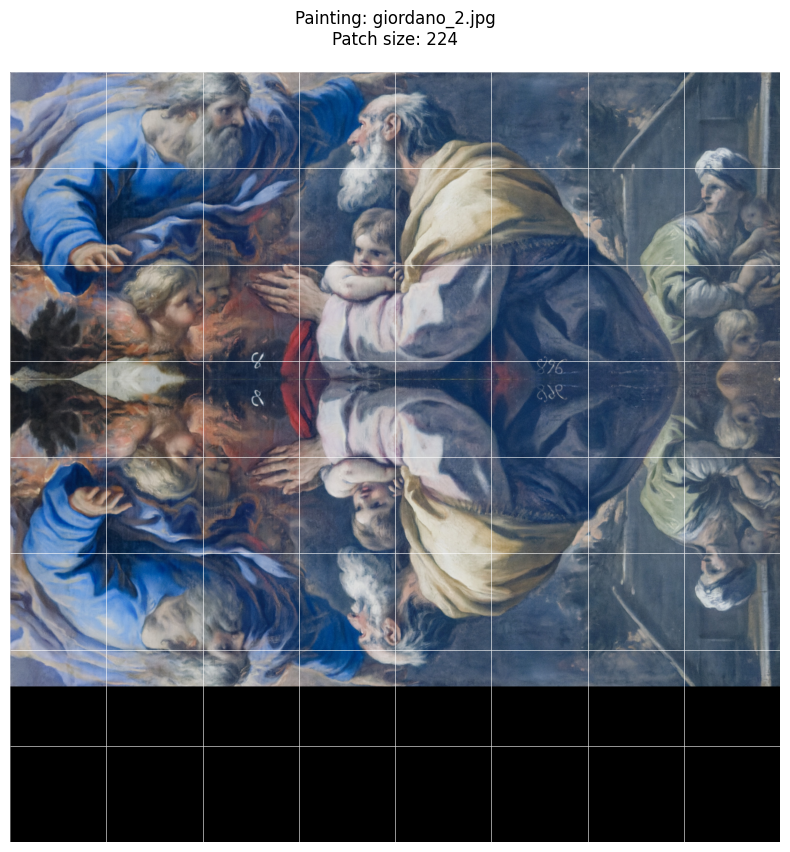

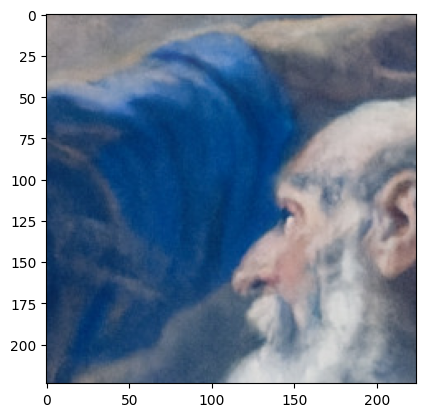

In [9]:
dict_patches=get__patches(index,idx=3233,show=True)  
plt.imshow(dict_patches['patches'][3])

In [10]:
def group_rectangular_similar_patches(patches_dict, threshold=0.2, show=False):
    """
    Regroupe les patches similaires et adjacents en formes rectangulaires/carrées.
    
    Args:
        patches_dict: Dictionnaire retourné par get__patches()
        threshold: Seuil de similarité (0-1), plus petit = regroupement plus strict
        show: Afficher le résultat si True
    
    Returns:
        Dictionnaire contenant les clusters rectangulaires
    """
    # Extraire les données
    patches_list = patches_dict['patches']
    positions = patches_dict['positions']
    img_np = patches_dict['image']
    patch_size = patches_dict['patch_size']
    
    # 1. Calculer les histogrammes couleur normalisés
    histograms = []
    for patch in patches_list:
        if len(patch.shape) == 3:  # Couleur
            hist = np.concatenate([
                cv2.calcHist([patch], [0], None, [8], [0, 256]).flatten(),
                cv2.calcHist([patch], [1], None, [8], [0, 256]).flatten(),
                cv2.calcHist([patch], [2], None, [8], [0, 256]).flatten()
            ])
        else:  # Niveaux de gris
            hist = cv2.calcHist([patch], [0], None, [8], [0, 256]).flatten()
        histograms.append(hist / (patch_size * patch_size))

    # 2. Calculer la matrice de similarité (cosinus)
    similarity_matrix = 1 - pairwise_distances(histograms, metric='cosine')
    
    # 3. Construire le graphe d'adjacence
    n = len(positions)
    adj_graph = {i: set() for i in range(n)}
    grid = {(x//patch_size, y//patch_size): i for i, (x,y) in enumerate(positions)}
    
    for (x,y), i in grid.items():
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:  # 4-connexité
            if (x+dx, y+dy) in grid:
                j = grid[(x+dx, y+dy)]
                adj_graph[i].add(j)
                adj_graph[j].add(i)
    
    # 4. Algorithme de regroupement initial
    visited = set()
    labels = np.zeros(n, dtype=int)
    current_label = 0
    
    for i in range(n):
        if i not in visited:
            queue = [i]
            visited.add(i)
            labels[i] = current_label
            
            while queue:
                node = queue.pop(0)
                for neighbor in adj_graph[node]:
                    if (neighbor not in visited and 
                        similarity_matrix[node, neighbor] >= (1 - threshold)):
                        visited.add(neighbor)
                        labels[neighbor] = current_label
                        queue.append(neighbor)
            
            current_label += 1
    
    # 5. Formation de clusters parfaitement rectangulaires
        from collections import defaultdict

    cluster_positions = defaultdict(list)
    for idx, label in enumerate(labels):
        cluster_positions[label].append(positions[idx])

    rectangular_clusters = []
    new_labels = np.zeros_like(labels)
    current_label = 0

    for cluster_id, original_positions in cluster_positions.items():
        if len(original_positions) < 2:
            continue

        # Coordonnées en grille
        grid_coords = {(x // patch_size, y // patch_size) for x, y in original_positions}
        min_x = min(x for x, y in grid_coords)
        max_x = max(x for x, y in grid_coords)
        min_y = min(y for x, y in grid_coords)
        max_y = max(y for x, y in grid_coords)

        # Rectangle englobant
        full_rect_coords = [(x, y) for x in range(min_x, max_x + 1) for y in range(min_y, max_y + 1)]

        # Indices initiaux pour calculer la similarité
        core_indices = [grid[(x, y)] for (x, y) in grid_coords if (x, y) in grid]
        if not core_indices:
            continue

        accepted_positions = []
        for (x, y) in full_rect_coords:
            if (x, y) in grid:
                idx = grid[(x, y)]
                # Moyenne de similarité avec le noyau
                similarities = [similarity_matrix[idx, j] for j in core_indices if j != idx]
                avg_sim = np.mean(similarities) if similarities else 0
                if avg_sim >= (1 - threshold):
                    accepted_positions.append((x * patch_size, y * patch_size))
            else:
                # Pas de patch original à cette position → à ignorer
                continue

        # Compléter le rectangle même si tous les patches ne sont pas dans le cluster initial
        for (x, y) in full_rect_coords:
            px, py = x * patch_size, y * patch_size
            if (x, y) in grid:
                idx = grid[(x, y)]
                new_labels[idx] = current_label
            accepted_positions.append((px, py))  # On complète visuellement

        # Stockage du rectangle
        width = (max_x - min_x + 1) * patch_size
        height = (max_y - min_y + 1) * patch_size
        rect_x = min_x * patch_size
        rect_y = min_y * patch_size

        rectangular_clusters.append({
            'rect': (rect_x, rect_y, width, height),
            'positions': accepted_positions,
            'perfect': True
        })

        current_label += 1

    # 7. Extraire les sous-images des rectangles
    cluster_zones = []
    for cluster in rectangular_clusters:
        x, y, w, h = cluster['rect']
        cluster_zone = img_np[y:y+h, x:x+w]  # Extraire la sous-image
        cluster_zones.append(cluster_zone)


    # 8. Visualisation
    if show:
        plt.figure(figsize=(12, 12))
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(f"Clusters rectangulaires stricts (seuil={threshold})", pad=20)
        
        ax = plt.gca()
        colors = plt.cm.get_cmap('tab10', len(rectangular_clusters))
        
        for cluster_id, cluster in enumerate(rectangular_clusters):
            x, y, width, height = cluster['rect']
            
            # Dessiner le rectangle
            rect = patches.Rectangle(
                (x, y), width, height,
                linewidth=2,
                edgecolor=colors(cluster_id),
                facecolor='none',
                alpha=0.7
            )
            ax.add_patch(rect)
            
            # Marquer les rectangles non-parfaits
            if not cluster['perfect']:
                ax.add_patch(patches.Rectangle(
                    (x, y), width, height,
                    linewidth=1,
                    edgecolor='red',
                    facecolor='none',
                    linestyle='--',
                    alpha=0.5
                ))
        
        plt.show()
    
    return {
    'image': img_np,
    'cluster_zones': cluster_zones,
    'rectangles': [cluster['rect'] for cluster in rectangular_clusters],
    'n_clusters': len(rectangular_clusters)
    }


idx de test : 
- 8054 marche plutot bien pour threshold a 0.15
- 8196 marche pas a 0.15 mais bien à 0.05
- 3233 enlever les clusters ou il y a trop de noir
- 6467 vraiment bien
- 4650


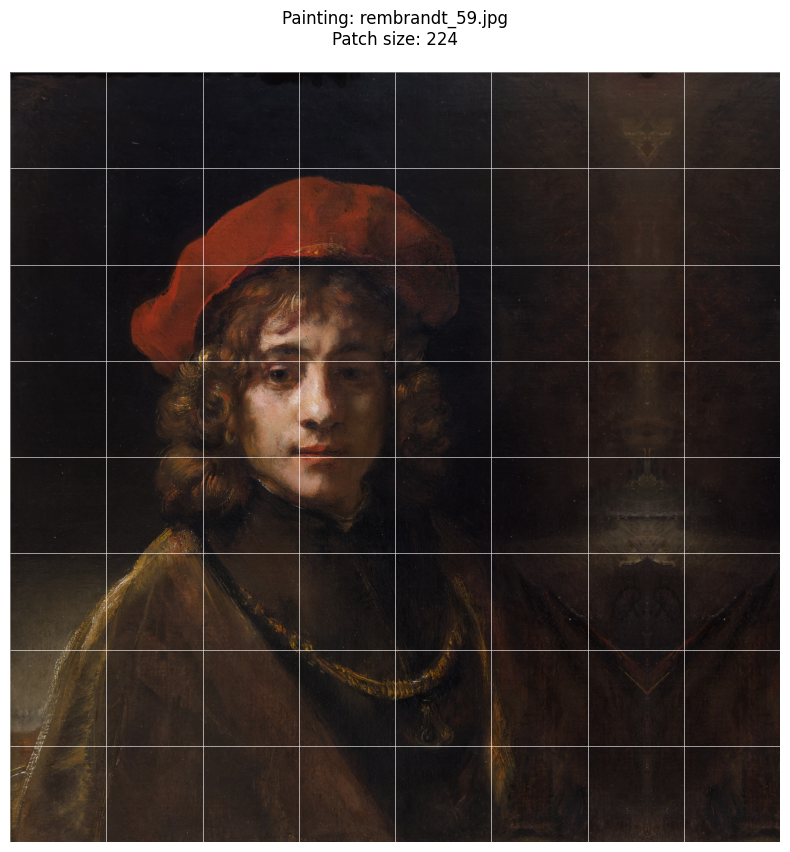

C:\Users\Titouan\AppData\Local\Temp\ipykernel_14476\1361486938.py:150: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(rectangular_clusters))


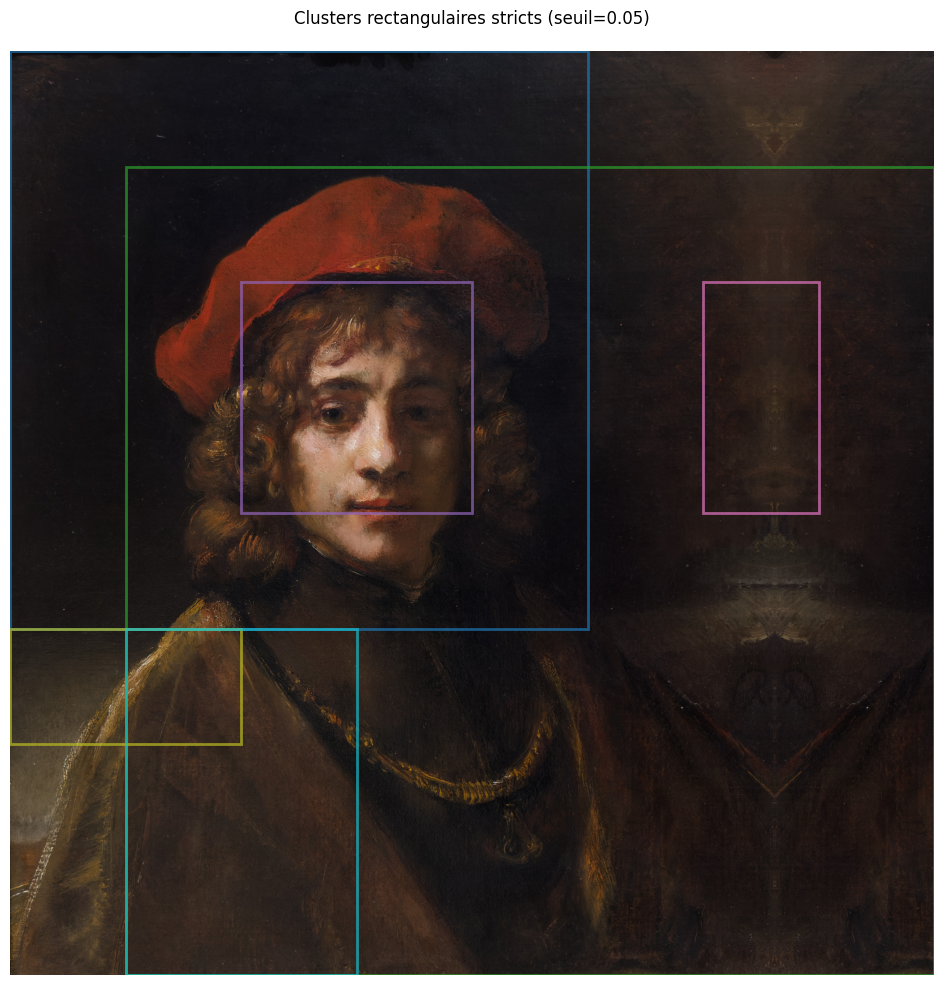

6 clusters found


In [11]:
# Obtenir les patches
patches_data = get__patches(index, idx=6467,show=True)

# Grouper les patches similaires adjacents
rectangular_patches = group_rectangular_similar_patches(patches_data, threshold=0.05, show=True)

# Analyser les résultats
print(f"{rectangular_patches['n_clusters']} clusters found")


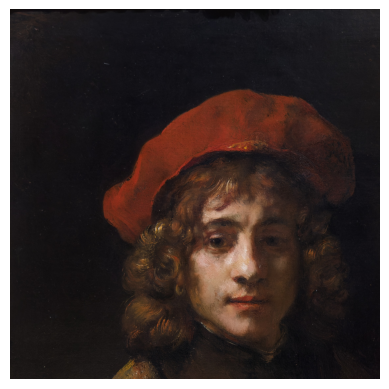

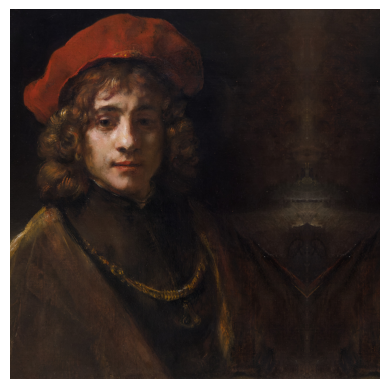

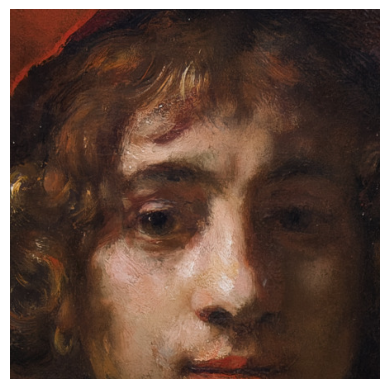

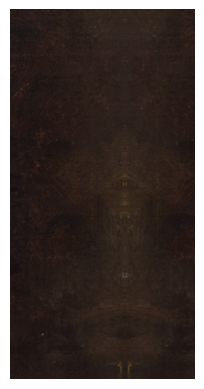

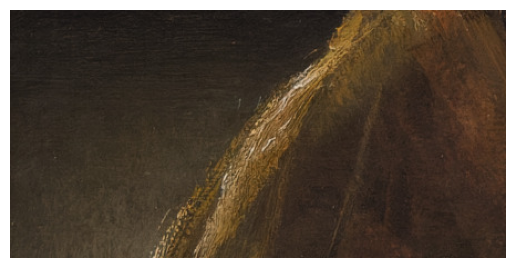

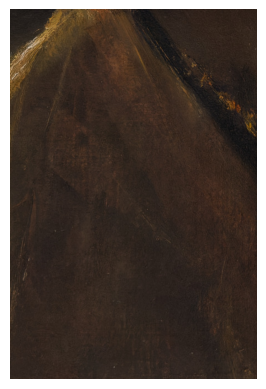

In [12]:
for i in range(rectangular_patches['n_clusters']):
    plt.imshow(rectangular_patches['cluster_zones'][i])
    plt.axis('off')
    plt.show()

# Models

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

label_texts = [
    #Context :
    "a battle", "a religious scene", "a mythological scene",

    #Landscape :
    "a seascape", "a forest", "a garden", "a tree", "sky", "water", "a cloud", "a mountain", "landscape",
    
    #Human :
    "a portrait", "a person", "a face", "people",

    #Animals :
    "horse", "lion", "dog", "bird", "deer", "sheep", "cow", "fish", 
    "snake", "dragon", "dove", 

    #Architectural elements :
    "a medieval castle", "a church", "a cathedral interior", "a temple", "a house", 
    "a palace", "a tower", "a ruin", "a stone bridge", "a garden with statues", "a city street", 

    "abstract shape", 

    #Objects:
    "a cross", "a sword", "a crown", "a musical instrument", "a book", 
    "a candle", "a vase", "a fruit basket", "a ship", "a halo", 
    "a globe", "a mask", "a statue", "a treasure chest",


    "mythology",
]

def classify_image_or_zones(images, label_texts, model, processor):
    """
    images : liste de np.array ou np.array unique
    Retourne liste de (label, confiance)
    """
    if not isinstance(images, list):
        images = [images]
    
    results = []
    for img in images:
        img_pil = Image.fromarray(img.astype('uint8'))
        inputs = processor(text=label_texts, images=img_pil, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image
            probs = logits_per_image.softmax(dim=1).cpu().numpy()[0]

        best_label = label_texts[int(probs.argmax())]
        results.append((best_label, float(probs.max())))
    return results

def analyze_painting(painting_data, label_texts, model, processor, show=False):
    """
    painting_data : dict avec keys 'image', 'cluster_zones', 'rectangles', 'n_clusters'
    show : bool, affiche plots si True
    
    Retourne dict avec classification image + zones
    """
    image = painting_data['image']
    zones = painting_data['cluster_zones']
    rects = painting_data['rectangles']

    # Classification image complète
    img_class = classify_image_or_zones(image, label_texts, model, processor)[0]

    # Classification zones
    zones_class = classify_image_or_zones(zones, label_texts, model, processor)

    # Résultats complets
    result = {
        "image": image,
        "image_class": img_class,
        "zones_class": zones_class,
        "rectangles": rects
    }

    if show:
        plt.figure(figsize=(15,8))
        plt.subplot(1,2,1)
        plt.title(f"Full Image: {img_class[0]} ({img_class[1]:.2f})")
        plt.imshow(image)
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(image)
        for i, ((label, conf), (x,y,w,h)) in enumerate(zip(zones_class, rects)):
            plt.gca().add_patch(plt.Rectangle((x,y), w, h, edgecolor='red', facecolor='none', lw=2))
            plt.text(x, y-5, f"{label} ({conf:.2f})", color='yellow', fontsize=9, bbox=dict(facecolor='black', alpha=0.5))
        plt.title(f"Zones ({len(zones_class)} clusters)")
        plt.axis('off')

        plt.show()

    return result

def compute_label_vector_max(analyze_result, label_texts, model, processor, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Retourne un vecteur de taille len(label_texts), où chaque case contient
    la probabilité maximale du label détectée dans l'image ou une de ses zones.
    """
    L = len(label_texts)
    label_vector = np.zeros(L)

    # Image entière
    full_image = analyze_result['image']
    img_pil = Image.fromarray(full_image.astype('uint8'))
    inputs = processor(text=label_texts, images=img_pil, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits_per_image
        probs = logits.softmax(dim=1).cpu().numpy()[0]
    label_vector = np.maximum(label_vector, probs)

    # Zones
    for (label, conf), (x, y, w, h) in zip(analyze_result['zones_class'], analyze_result["rectangles"]):
        zone_img = full_image[y:y+h, x:x+w]
        img_pil = Image.fromarray(zone_img.astype('uint8'))
        inputs = processor(text=label_texts, images=img_pil, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits_per_image
            probs_zone = logits.softmax(dim=1).cpu().numpy()[0]
        label_vector = np.maximum(label_vector, probs_zone)  # max-pooling

    return label_vector

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [14]:
def plot_top_labels(label_vector, label_texts, top_k=5):
    """
    Affiche un bar plot des top_k labels les plus probables.
    """
    # Sélection des top_k indices
    top_indices = np.argsort(label_vector)[-top_k:][::-1]
    top_scores = label_vector[top_indices]
    top_labels = [label_texts[i] for i in top_indices]

    # Affichage
    plt.figure(figsize=(10, 5))
    plt.barh(range(top_k), top_scores[::-1], color='skyblue')
    plt.yticks(range(top_k), top_labels[::-1])
    plt.xlabel("Confidence")
    plt.title(f"Top {top_k} detected labels")
    plt.tight_layout()
    plt.show()


Randomly selected index: 8021


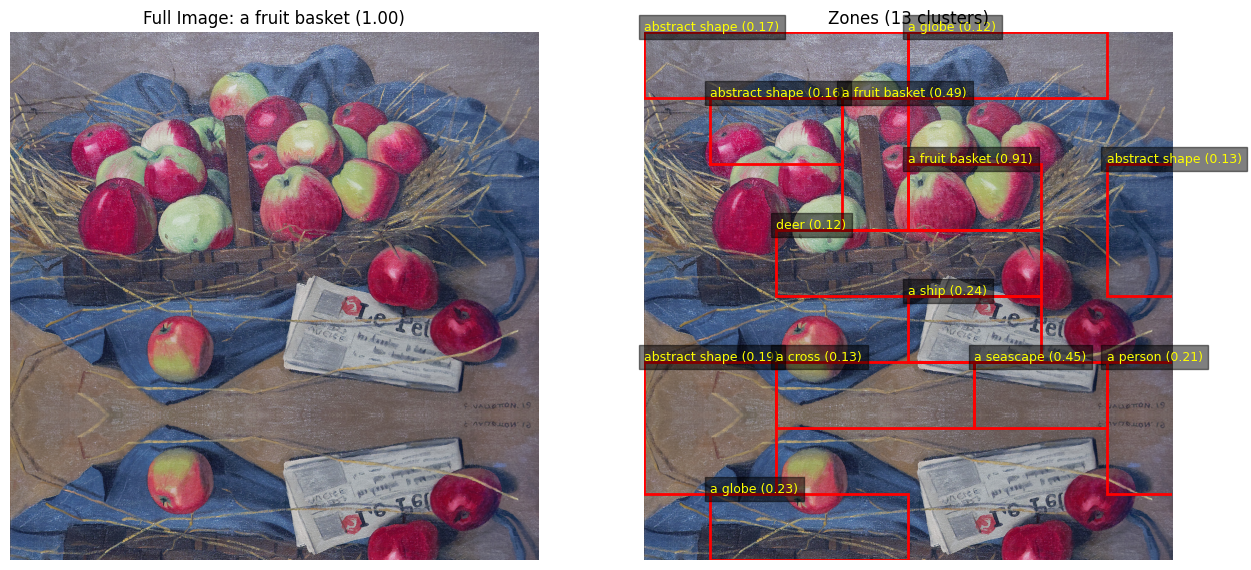

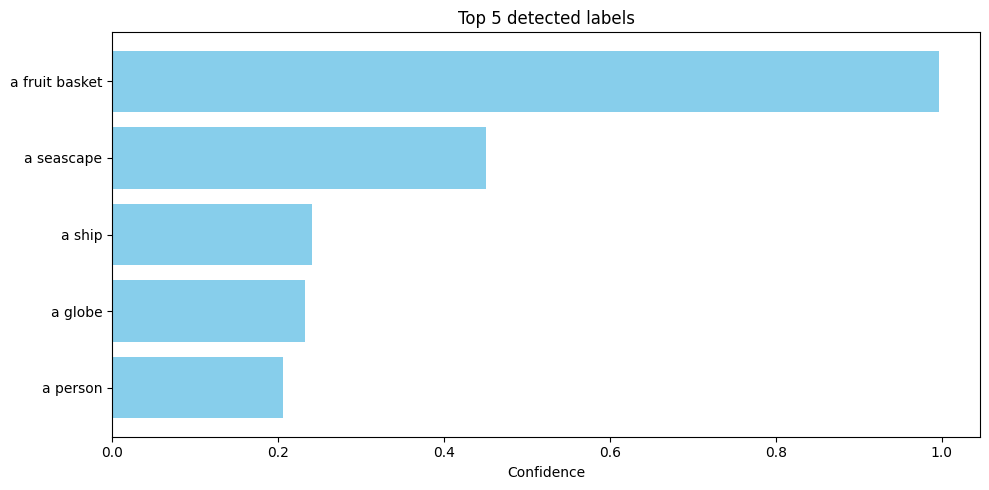

Randomly selected index: 2535


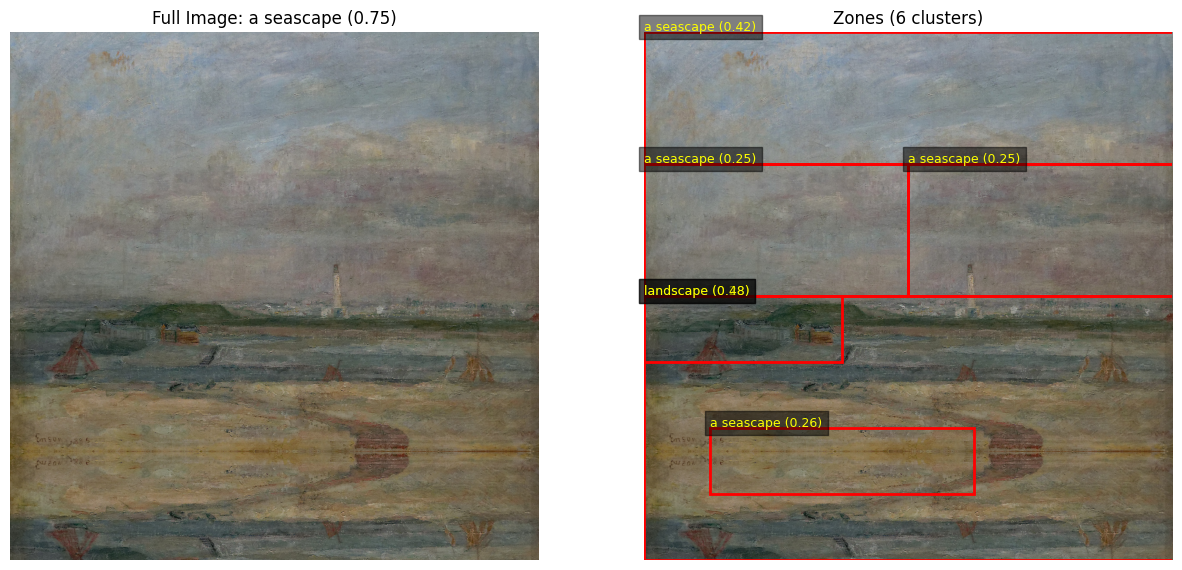

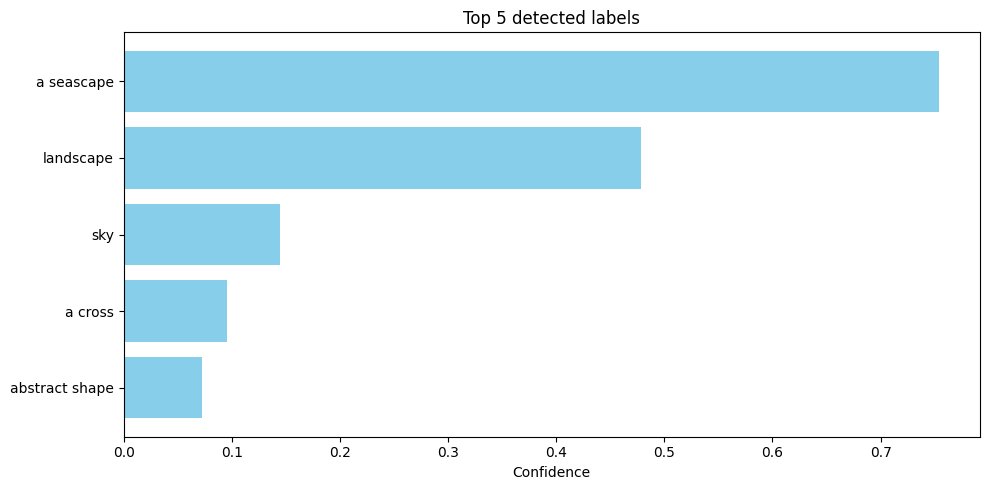

In [15]:
# --- Test avec ton code ---
test_list= [6467, 8196, 3233, 8054, 4650]
for i in range(2): 
    patches_data = get__patches(index, show=False)
    rectangular_patches = group_rectangular_similar_patches(patches_data, threshold=0.05, show=False)

    res = analyze_painting(rectangular_patches, label_texts, model, processor, show=True)

    vec = compute_label_vector_max(res, label_texts, model, processor)
    plot_top_labels(vec, label_texts, top_k=5)


In [16]:
def extract_vectors_and_metadata(index, label_texts, model, processor, max_images=None, shuffle=True):
    """
    Parcourt l'index pour extraire les vecteurs sémantiques des images.

    Args:
        index (dict): dictionnaire contenant les chemins et les métadonnées.
        label_texts (list): les labels à classer.
        model, processor: modèle CLIP.
        max_images (int): nombre maximum d'images à traiter (None = toutes).
        shuffle (bool): mélanger les images avant de sélectionner.

    Returns:
        - vecteurs (np.ndarray)
        - chemins des images
        - codes artistes
    """
    all_vectors = []
    image_paths = []
    artist_codes = []

    keys = list(index.keys())
    if shuffle:
        np.random.shuffle(keys)
    if max_images is not None:
        keys = keys[:max_images]

    for path in tqdm(keys, desc=f"Processing {len(keys)} paintings"):
        try:
            img = Image.open(path).convert("RGB")
            img_np = np.array(img)

            painting_data = {
                'image': img_np,
                'cluster_zones': [],
                'rectangles': [],
                'n_clusters': 0
            }

            result = analyze_painting(painting_data, label_texts, model, processor, show=False)
            vec = compute_label_vector_max(result, label_texts, model, processor)

            all_vectors.append(vec)
            image_paths.append(path)
            artist_codes.append(index[path]["artist_code"])

        except Exception as e:
            print(f"Erreur avec {path} : {e}")
            continue

    return np.vstack(all_vectors), image_paths, artist_codes


def plot_pca_with_artists(vectors, image_paths, artist_codes, index, n_components=5, image_size=32):
    # PCA
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(vectors)

    # Mapping couleurs artistes
    unique_artists = sorted(list(set(artist_codes)))
    cmap = cm.get_cmap('tab20', len(unique_artists))
    artist_to_color = {artist: cmap(i) for i, artist in enumerate(unique_artists)}
    colors = [artist_to_color[code] for code in artist_codes]

    # Plot
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_title("Projection PCA des peintures - Couleur par artiste", fontsize=16)

    for (x, y), path, color in zip(reduced[:, :2], image_paths, colors):
        img = Image.open(path).convert("RGB").resize((image_size, image_size))
        imagebox = OffsetImage(np.array(img), zoom=1.0)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)
        ax.plot(x, y, 'o', color=color, markersize=5)

    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.grid(True)

    # Légende artistes
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          label=index, markerfacecolor=artist_to_color[index], markersize=8)
               for index in unique_artists]
    ax.legend(handles=handles, title="Artistes", loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

    return reduced


Processing 4000 paintings:   0%|          | 0/4000 [00:00<?, ?it/s]

Processing 4000 paintings: 100%|██████████| 4000/4000 [2:09:38<00:00,  1.94s/it]  


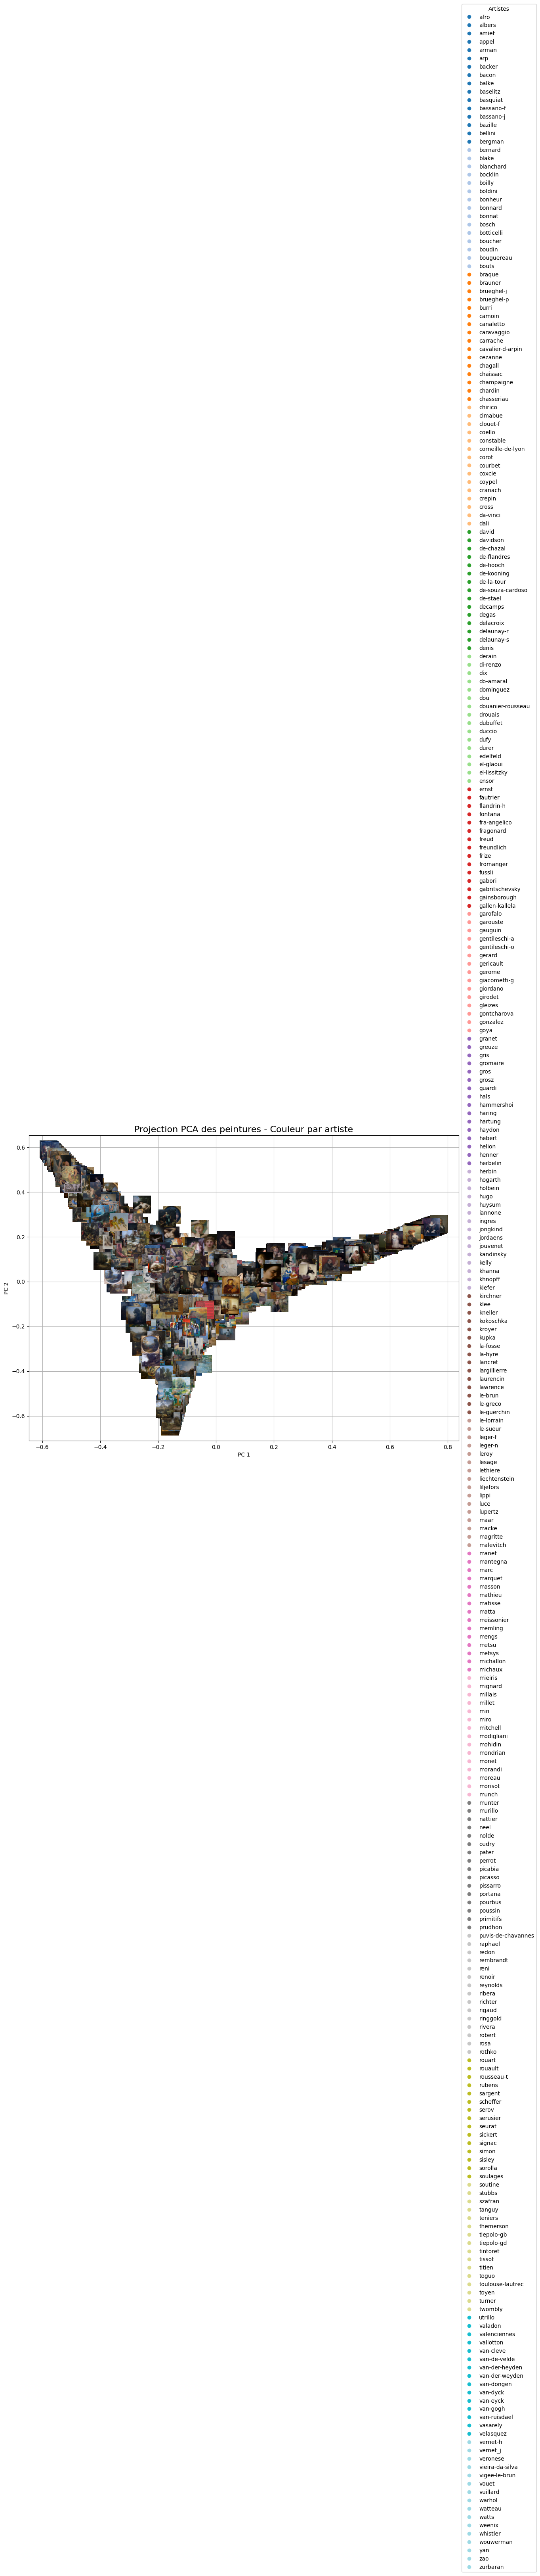

In [68]:
vectors, paths, artists = extract_vectors_and_metadata(index, label_texts, model, processor, max_images=4000)
reduced = plot_pca_with_artists(vectors, paths, artists, index)


In [ ]:
import plotly.express as px
import pandas as pd
import os
import ipywidgets as widgets
from IPython.display import display

def interactive_pca_plot_with_fixed_axes(vectors, image_paths, artist_codes, index):
    # Construction du DataFrame
    df = pd.DataFrame({
        "PC1": vectors[:, 1],
        "PC2": vectors[:, 2],
        "artist_code": artist_codes,
        "artist_name": [index[p]["full_name"] for p in image_paths],
        "filename": [os.path.basename(p) for p in image_paths],
        "path": image_paths
    })

    # Détermination des bornes globales
    x_range = [df["PC1"].min(), df["PC1"].max()]
    y_range = [df["PC2"].min(), df["PC2"].max()]

    # Liste des artistes disponibles
    artist_list = sorted(df["artist_code"].unique())

    # Widget de sélection multiple
    artist_selector = widgets.SelectMultiple(
        options=artist_list,
        value=artist_list[:5],
        description='Artistes',
        layout=widgets.Layout(width='40%'),
        style={'description_width': 'initial'}
    )

    # Fonction de mise à jour du plot
    def update_plot(selected_artists):
        filtered_df = df[df["artist_code"].isin(selected_artists)]
        fig = px.scatter(
            filtered_df, x="PC1", y="PC2",
            color="artist_code",
            hover_data=["filename", "artist_name"],
            title="Projection PCA interactive des peintures par artiste",
            labels={"PC1": "Première composante principale", "PC2": "Deuxième composante principale"},
            width=900, height=700
        )
        fig.update_traces(marker=dict(size=8, line=dict(width=0.5, color='DarkSlateGrey')))
        fig.update_layout(
            legend_title_text='Artiste (code)',
            xaxis_range=x_range,
            yaxis_range=y_range
        )
        fig.show()

    # Liaison du widget à la fonction
    widgets.interact(update_plot, selected_artists=artist_selector)



interactive_pca_plot_with_fixed_axes(reduced, paths, artists, index)


interactive(children=(SelectMultiple(description='Artistes', index=(0, 1, 2, 3, 4), layout=Layout(width='40%')…

# Test

In [20]:
def extract_color_features(index, k=3, idx=None):
    # Handle different input types
    if isinstance(idx, str):  # Direct path provided
        path = idx
    elif isinstance(idx, int):  # Numerical index provided
        path = list(index.keys())[idx]
    else:  # Random selection if no index specified
        keys_list = list(index.keys())
        random_idx = np.random.randint(0, len(keys_list))
        path = keys_list[random_idx]
        print(f"Randomly selected index: {random_idx}")
        
    # Load and convert image
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pixels = img.reshape(-1, 3)
    
    # K-means for dominant colors
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)
    dominant_colors = kmeans.cluster_centers_
    color_percentages = np.bincount(kmeans.labels_) / len(pixels)
    
    # 2. Globals statistics
    mean = np.mean(pixels, axis=0)
    std = np.std(pixels, axis=0)
    
    # Combine features
    # Create feature dictionary with descriptive names
    features = {
        # Global color statistics
        'mean_R': mean[0],
        'mean_G': mean[1],
        'mean_B': mean[2],
        'std_R': std[0],
        'std_G': std[1],
        'std_B': std[2],
        
        # Dominant colors and their percentages
        **{f'dominant_color_{i}_R': dominant_colors[i][0] for i in range(k)},
        **{f'dominant_color_{i}_G': dominant_colors[i][1] for i in range(k)},
        **{f'dominant_color_{i}_B': dominant_colors[i][2] for i in range(k)},
        **{f'color_percentage_{i}': color_percentages[i] for i in range(k)}
    }
    
    return features


In [19]:
def extract_texture_features(index, idx=None, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """
    Extrait des features de texture via GLCM (Gray-Level Co-occurrence Matrix)
    
    Args:
        index: Dictionnaire des images
        idx: Index ou chemin de l'image
        distances: Liste des distances pour GLCM (par défaut [1])
        angles: Liste des angles pour GLCM (par défaut 0°, 45°, 90°, 135°)
    
    Returns:
        Dictionnaire des features de texture
    """
    # Gestion des entrées (identique à extract_color_features)
    if isinstance(idx, str):
        path = idx
    elif isinstance(idx, int):
        path = list(index.keys())[idx]
    else:
        keys_list = list(index.keys())
        random_idx = np.random.randint(0, len(keys_list))
        path = keys_list[random_idx]
        print(f"Randomly selected index: {random_idx}")
    
    # Chargement de l'image en niveaux de gris
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    # Quantification des niveaux de gris (réduit de 256 à 16 niveaux pour GLCM)
    img_quantized = (img // 16).astype('uint8')
    
    # Calcul de la matrice GLCM
    glcm = graycomatrix(img_quantized, 
                       distances=distances, 
                       angles=angles,
                       levels=16,
                       symmetric=True)
    
    # Calcul des propriétés de texture
    features = {
        'texture_contrast': np.mean(graycoprops(glcm, 'contrast')),
        'texture_dissimilarity': np.mean(graycoprops(glcm, 'dissimilarity')),
        'texture_homogeneity': np.mean(graycoprops(glcm, 'homogeneity')),
        'texture_energy': np.mean(graycoprops(glcm, 'energy')),
        'texture_correlation': np.mean(graycoprops(glcm, 'correlation')),
        'texture_ASM': np.mean(graycoprops(glcm, 'ASM'))  # Angular Second Moment
    }
    
    return features

In [17]:
def create_features_csv(index, output_file="features.csv", k=3, max_paintings=None, force_update=False):
    """
    Crée/màj un CSV de features avec contrôle du nombre de peintures à traiter.
    
    Args:
        index (dict): Index des peintures {path: metadata}
        output_file (str): Chemin du fichier de sortie
        k (int): Nombre de couleurs dominantes
        max_paintings (int): Nombre max de peintures à traiter (None = toutes)
        force_update (bool): Recalculer même si peinture déjà existante
    """
    # Charger ou initialiser le DataFrame
    if os.path.exists(output_file) and not force_update:
        df = pd.read_csv(output_file)
        existing_ids = set(df['painting_id'])
        print(f"{len(existing_ids)} peintures déjà dans le fichier")
    else:
        df = pd.DataFrame()
        existing_ids = set()
        print("Création d'un nouveau fichier")

    # Préparer la liste des peintures à traiter
    paintings_to_process = []
    count = 0
    
    for img_path, metadata in index.items():
        painting_id = os.path.splitext(os.path.basename(img_path))[0]
        
        if painting_id not in existing_ids:
            paintings_to_process.append((img_path, metadata, painting_id))
            count += 1
            if max_paintings and count >= max_paintings:
                break

    print(f"{len(paintings_to_process)} nouvelles peintures à traiter")

    # Traitement avec barre de progression
    for i, (img_path, metadata, painting_id) in enumerate(tqdm(paintings_to_process, desc="Extraction des features")):
        try:
            new_row = {
                'painting_id': painting_id,
                'artist': metadata['full_name'],
                'artist_code': metadata['artist_code'],
                'birth_year': metadata['birth_year'],
                'dimensions': f"{metadata['width']}x{metadata['height']}",
            }
            features = extract_color_features(index, k=k, idx=img_path)
            new_row.update(features)
            features = extract_texture_features(index, idx=img_path)
            new_row.update(features)
            
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
            
            # Sauvegarde temporaire tous les 20 éléments
            if i % 20 == 0:
                df.to_csv(output_file, index=False)
                
        except Exception as e:
            print(f"\nErreur sur {img_path}: {str(e)}")
            continue

    # Sauvegarde finale
    if not df.empty:
        final_output_exists = os.path.exists(output_file)
        mode = 'a' if final_output_exists and not force_update else 'w'
        header = not final_output_exists or force_update
        
        df.to_csv(output_file, mode=mode, header=header, index=False)
        print(f"\nFichier mis à jour : {output_file}")
        print(f"Peintures ajoutées : {len(paintings_to_process)}")
        print(f"Total peintures dans le fichier : {len(existing_ids) + len(paintings_to_process)}")
    else:
        print("\nAucune nouvelle peinture à ajouter")

    return df

In [32]:
df = create_features_csv(index, max_paintings=500, force_update=False)

500 peintures déjà dans le fichier
500 nouvelles peintures à traiter


Extraction des features: 100%|██████████| 500/500 [16:14<00:00,  1.95s/it]


Fichier mis à jour : features.csv
Peintures ajoutées : 500
Total peintures dans le fichier : 1000


In [29]:
df.head()

painting_id           artist artist_code  birth_year dimensions      mean_R  \
0      afro_1  afro-basaldella        afro        1912  1800x1441  138.727758   
1      afro_2  afro-basaldella        afro        1912  1800x1365   75.174770   
2      afro_3  afro-basaldella        afro        1912  1800x1298  125.201644   
3      afro_4  afro-basaldella        afro        1912  1800x1609  149.295235   
4      afro_5  afro-basaldella        afro        1912   1800x895  104.193128   

       mean_G      mean_B      std_R      std_G  ...  color_percentage_1  \
0  129.264404  113.612096  62.261920  59.450076  ...            0.334296   
1  110.790928  128.961582  69.586415  60.217570  ...            0.144537   
2  122.693576  105.484379  21.137200  18.769405  ...            0.306318   
3   73.909884   71.039216  34.246157  52.959087  ...            0.185902   
4   97.758813   89.276205  33.789919  28.359871  ...            0.283700   

   color_percentage_2  color_percentage_3  color_percentage_4  \
0            0.287647            0.210266            0.078897   
1            0.176830            0.381771            0.052632   
2            0.159167            0.146785            0.321680   
3            0.279231            0.190556            0.110180   
4            0.104135            0.159930            0.239448   

   texture_contrast  texture_dissimilarity  texture_homogeneity  \
0          1.941186               0.605651             0.787053   
1          0.431884               0.324573             0.847565   
2          0.222607               0.219033             0.890840   
3          0.338001               0.315195             0.844682   
4          0.414997               0.340037             0.836965   

   texture_energy  texture_correlation  texture_ASM  
0        0.242623             0.929774     0.058898  
1        0.233132             0.984904     0.054454  
2        0.430542             0.921097     0.185393  
3        0.266957             0.975961     0.071275  
4        0.297046             0.937897     0.088260  

[5 rows x 37 columns]

# Plot

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.io import imread
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import json
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import os

def plot_pca_with_images(features_csv='features.csv', index_json='index.json',
                         n_components=3, image_zoom=0.05, interactive=False):
    """
    Affiche soit 3 plots PCA avec les images projetées, soit un plot interactif avec plotly.
    
    Args:
        features_csv: Chemin vers le fichier CSV des features.
        index_json: Chemin vers le fichier JSON de l'index (avec metadata).
        n_components: Nombre de composantes principales à calculer.
        image_zoom: Facteur de zoom des images dans les plots matplotlib.
        interactive: Booléen pour choisir le mode interactif Plotly (True) ou images projetées (False).
    """

    # Chargement des données
    df = pd.read_csv(features_csv)
    with open(index_json) as f:
        index = json.load(f)

    # Colonnes des features (on exclut les métadonnées)
    exclude_cols = ['painting_id', 'artist', 'artist_code', 'birth_year', 'dimensions']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    X = df[feature_cols].values

    # Standardisation
    X_std = (X - X.mean(axis=0)) / X.std(axis=0)

    # PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X_std)
    pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

    # Ajout des colonnes utiles
    pc_df['path'] = list(index.keys())[:len(df)]
    pc_df['artist_code'] = df['artist_code'].values

    if interactive:
        # Pour le mode interactif avec plotly
        pc_df['artist_name'] = [index[path]["full_name"] if path in index else "?" for path in pc_df['path']]
        pc_df['filename'] = [os.path.basename(p) for p in pc_df['path']]

        # Ranges fixes
        x_range = [pc_df["PC1"].min(), pc_df["PC1"].max()]
        y_range = [pc_df["PC2"].min(), pc_df["PC2"].max()]

        artist_list = sorted(pc_df["artist_code"].unique())

        artist_selector = widgets.SelectMultiple(
            options=artist_list,
            value=artist_list[:5],
            description='Artistes',
            layout=widgets.Layout(width='40%'),
            style={'description_width': 'initial'}
        )

        def update_plot(selected_artists):
            filtered_df = pc_df[pc_df["artist_code"].isin(selected_artists)]
            fig = px.scatter(
                filtered_df, x="PC1", y="PC2",
                color="artist_code",
                hover_data=["filename", "artist_name"],
                title="Projection PCA interactive des peintures par artiste",
                labels={"PC1": "Première composante principale", "PC2": "Deuxième composante principale"},
                width=900, height=700
            )
            fig.update_traces(marker=dict(size=8, line=dict(width=0.5, color='DarkSlateGrey')))
            fig.update_layout(
                legend_title_text='Artiste (code)',
                xaxis_range=x_range,
                yaxis_range=y_range
            )
            fig.show()

        widgets.interact(update_plot, selected_artists=artist_selector)

    else:
        """ # Mode classique : plot des images projetées
        def image_scatter(x, y, images, ax=None, zoom=1):
            if ax is None:
                ax = plt.gca()
            x, y = np.atleast_1d(x), np.atleast_1d(y)
            for x0, y0, img in zip(x, y, images):
                try:
                    image = imread(img)
                    im = OffsetImage(image, zoom=zoom)
                    ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
                    ax.add_artist(ab)
                except Exception as e:
                    print(f"Erreur chargement {img}: {e}")
            ax.update_datalim(np.column_stack([x, y]))
            ax.autoscale()

        # PC1 vs PC2
        plt.figure(figsize=(8, 6))
        image_scatter(pc_df['PC1'], pc_df['PC2'], pc_df['path'], zoom=image_zoom)
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.title('PCA : PC1 vs PC2')
        plt.grid(True)

        """ # PC1 vs PC3
        plt.figure(figsize=(8, 6))
        image_scatter(pc_df['PC1'], pc_df['PC3'], pc_df['path'], zoom=image_zoom)
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
        plt.title('PCA : PC1 vs PC3')
        plt.grid(True)

        # PC2 vs PC3
        plt.figure(figsize=(8, 6))
        image_scatter(pc_df['PC2'], pc_df['PC3'], pc_df['path'], zoom=image_zoom)
        plt.xlabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
        plt.title('PCA : PC2 vs PC3')
        plt.grid(True) """

        plt.show() """

    return pca, pc_df


In [ ]:
pca, pc_df = plot_pca_with_images(
    features_csv='features.csv',
    index_json='index.json',
    n_components=3,
    image_zoom=0.02, 
    interactive=True  )

interactive(children=(SelectMultiple(description='Artistes', index=(0, 1, 2, 3, 4), layout=Layout(width='40%')…